In [65]:
import sys
from pathlib import Path
sys.path.append(str(Path('__file__').resolve().parent.parent.parent))

In [66]:
from configs.data import INPUT_DIR, OUTPUT_DIR
from configs.lightGBM import Config
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [67]:
train = pd.read_csv(INPUT_DIR + 'train.csv')
test = pd.read_csv(INPUT_DIR + 'test.csv')

In [68]:
train.head()

,id,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,...,f_22,f_23,f_24,f_25,f_26,f_27,f_28,f_29,f_30,target
0,0,-1.373246,0.238887,-0.243376,0.567405,-0.647715,0.839326,0.113133,1,5,...,-2.540739,0.766952,-2.730628,-0.208177,1.363402,ABABDADBAB,67.609153,0,0,0
1,1,1.697021,-1.710322,-2.230332,-0.545661,1.113173,-1.552175,0.447825,1,3,...,2.278315,-0.633658,-1.217077,-3.782194,-0.058316,ACACCADCEB,377.096415,0,0,1
2,2,1.681726,0.616746,-1.027689,0.810492,-0.609086,0.113965,-0.708660,1,0,...,-1.385775,-0.520558,-0.009121,2.788536,-3.703488,AAAEABCKAD,-195.599702,0,2,1
3,3,-0.118172,-0.587835,-0.804638,2.086822,0.371005,-0.128831,-0.282575,3,2,...,0.572594,-1.653213,1.686035,-2.533098,-0.608601,BDBBAACBCB,210.826205,0,0,1
4,4,1.148481,-0.176567,-0.664871,-1.101343,0.467875,0.500117,0.407515,3,3,...,-3.912929,-1.430366,2.127649,-3.306784,4.371371,BDBCBBCHFE,-217.211798,0,1,1


In [69]:
train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900000 entries, 0 to 899999
Data columns (total 33 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      900000 non-null  int64  
 1   f_00    900000 non-null  float64
 2   f_01    900000 non-null  float64
 3   f_02    900000 non-null  float64
 4   f_03    900000 non-null  float64
 5   f_04    900000 non-null  float64
 6   f_05    900000 non-null  float64
 7   f_06    900000 non-null  float64
 8   f_07    900000 non-null  int64  
 9   f_08    900000 non-null  int64  
 10  f_09    900000 non-null  int64  
 11  f_10    900000 non-null  int64  
 12  f_11    900000 non-null  int64  
 13  f_12    900000 non-null  int64  
 14  f_13    900000 non-null  int64  
 15  f_14    900000 non-null  int64  
 16  f_15    900000 non-null  int64  
 17  f_16    900000 non-null  int64  
 18  f_17    900000 non-null  int64  
 19  f_18    900000 non-null  int64  
 20  f_19    900000 non-null  float64
 21  f_20    90

# Preprocess

In [70]:
from sklearn.preprocessing import OrdinalEncoder

oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
oe.fit(train['f_27'].values.reshape(-1,1))
train['f_27'] = oe.transform(train['f_27'].values.reshape(-1,1))
test['f_27'] = oe.transform(test['f_27'].values.reshape(-1,1))

# Train model

In [71]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import lightgbm as lgbm

def fit_lgbm(train, params):
    models = []
    valid_scores = []
    
    kf = KFold(n_splits=Config.n_splits)
    train_y = train.pop(Config.target)
    train_X = train
    
    for fold, (train_indices, valid_indices) in enumerate(kf.split(X=train_X, y=train_y)):
        X_train, X_valid = train_X.iloc[train_indices], train_X.iloc[valid_indices]
        y_train, y_valid = train_y.iloc[train_indices], train_y.iloc[valid_indices]
        
        model = lgbm.LGBMClassifier(**params,
                                    boosting_type='gbdt',
                                    objective='binary',
                                    random_state=Config.seed, 
                                    verbose=-1)
        model.fit(X_train, y_train)
        
        y_valid_pred = model.predict_proba(X=X_valid)
        y_valid_pred = np.argmax(y_valid_pred, axis=1)
        score = roc_auc_score(y_true=y_valid, y_score=y_valid_pred)
        
        print(f'fold {fold} RMSE: {score}')
        valid_scores.append(score)
        models.append(model)
    
    cv_score = np.mean(valid_scores)
    print(f'CV score: {cv_score}')
    return models

def inference_lgbm(models, feat):
    pred = np.array([model.predict_proba(feat) for model in models])   
    pred = np.argmax(np.mean(pred, axis=0) , axis=1)
    return pred

In [72]:
train.drop(['id'], axis=1, inplace=True)
feat = test.drop(['id'], axis=1)

In [73]:
params = {
    'learning_rate': 0.1,
    'reg_alpha': 0,
    'reg_lambda': 0,
    'num_leaves': 31,
    'colsample_bytree': 1.0,
    'subsample': 1.0,
    'subsample_freq': 0,
    'min_child_samples': 20
}

models = fit_lgbm(train=train, params=params)
pred = inference_lgbm(models=models, feat=feat)

fold 0 RMSE: 0.8314500504306432
fold 1 RMSE: 0.8316707454240342
fold 2 RMSE: 0.832934290095813
fold 3 RMSE: 0.832360691847257
fold 4 RMSE: 0.8308530919487319
CV score: 0.8318537739492958


# Postprocess

In [74]:
def plot_importances(model):
    importance_df = pd.DataFrame(model.feature_importances_, 
                                 index=model.feature_name_, 
                                 columns=['importance'])\
                        .sort_values("importance", ascending=False)

    plt.subplots(figsize=(len(model.feature_name_) // 4, 5))
    plt.bar(importance_df.index, importance_df.importance)
    plt.grid()
    plt.xticks(rotation=90)
    plt.ylabel("importance")
    plt.tight_layout()
    plt.show()

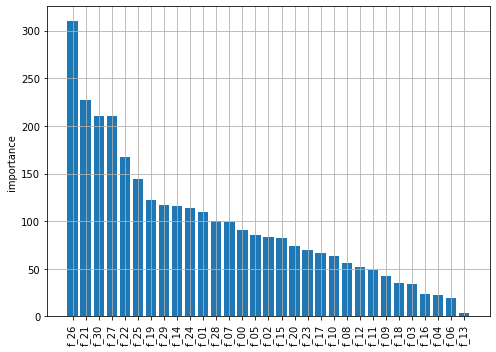

In [75]:
plot_importances(model=models[0])

# Submission

In [76]:
sub = pd.read_csv(INPUT_DIR + 'sample_submission.csv')
test[Config.target] = pred
sub = test.loc[:, ['id', Config.target]].reset_index(drop=True)
sub.to_csv(OUTPUT_DIR + 'lgbm_baseline.csv', index=False)